### Analysis of *-seq data from satellite monomers

In [1]:
from __future__ import division
%pylab inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from scipy.stats import kendalltau,pearsonr,spearmanr

Populating the interactive namespace from numpy and matplotlib


In [4]:
def parse_monomer_cvg(fn,norm=False):
    data = {}
    reads = {}
    with open(fn,'r') as f:
        for line in f:
            line = line.strip().split()
            name = line[0] + ':' + line[1] + '-' + line[2]
            cvg = int(line[-1])
            data[name] = cvg
            
            if line[0] in reads:
                reads[line[0]] += cvg
            else:
                reads[line[0]] = cvg
    
    if norm:
        tot = 0
        for name in reads.keys():
            tot += reads[name]
        
        for name in data.keys():
            chrom = name.split(':')[0]
            if reads[chrom] != 0:
                data[name] *= reads[chrom]/tot
            
    return data

def parse_rnafold(fn):
    ctr = 0
    data = {}
    with open(fn,'r') as f:
        for line in f:
            line = line.rstrip()
            if '>' == line[0]:
                name = line.strip('>')
                data[name] = {}
                ctr = 0
            elif ctr == 1:
                data[name]['seq'] = line
            elif ctr == 2:
                line = line.split()
                data[name]['mfe_deltaG'] = float(line[-1].strip('()'))
            elif ctr == 3:
                line = line.split()
                data[name]['ensemble_deltaG'] = float(line[-1].strip('[]'))
            ctr +=1
    return data

def parse_nearest(fn):
    data = {}
    nboxes = {}
    with open(fn,'r') as f:
        for line in f:
            line = line.rstrip().split()
            name = line[0] + ':' + line[1] + '-' + line[2]
            data[name] = {}
            data[name]['d'] = int(line[-1])
            try:
                data[name]['score'] = float(line[-3])
            except:
                data[name]['score'] = '-1'
                
                
            if line[0] not in nboxes:
                nboxes[line[0]] = 1
            else:
                nboxes[line[0]] += 1
    return data,nboxes

In [3]:
cenpa_d = parse_monomer_cvg('../data/cenpa_huref.cons_mono.cvg',norm=False)
ssdna_d = parse_monomer_cvg('../data/raji_ssdna.cons_mono.cvg',norm=False)
norm_d = parse_monomer_cvg('../data/input.human_no_ambig.cons_mono.cvg',norm=True)
norm_d2 = parse_monomer_cvg('../data/NA12877.cons_mono.cvg',norm=True)
fold_d = parse_rnafold('../data/cons_mono.rnafold.txt')
box_d, nb_d= parse_nearest('../data/human_asat.1.25kb.no_ambig.cons_mono.closest_b.bed')

names = sorted(cenpa_d.keys())
# names = sorted(fold_d.keys())

cenpa = np.array([cenpa_d[name] for name in names],dtype=float)
ssdna = np.array([ssdna_d[name] for name in names],dtype=float)
norm = np.array([norm_d[name] for name in names],dtype=float)
norm2 = np.array([norm_d2[name] for name in names],dtype=float)


fold = np.array([fold_d[name]['ensemble_deltaG'] for name in names],dtype=float)
boxdist = np.array([box_d[name]['d'] for name in names],dtype=float)
boxscore = np.array([box_d[name]['score'] for name in names],dtype=float)
# nb = np.array([nb_d[name] for name in names])

In [298]:
def parse_nearest_filter(fn,names=None,normbed=None):
    """Parse the bedtools nearest output; limit monomers that are within delta of
    the ends of the Sanger read"""
    
    if names is None:
        nom = {}
    else:
        nom=names
    
    norm = {}
    if normbed is not None:
        with open(normbed,'r') as f:
            for line in f:
                line = line.rstrip().split()
                if len(line) >= 12:
                    n = line[0]+':'+line[1]+':'+line[2] + ';' + line[10]+':'+line[11]+':'+line[12]
                    norm[n] = float(line[8])
    
    arr = []
    with open(fn,'r') as f:
        for line in f:
            line = line.rstrip().split()
            
            n = line[0]+':'+line[1]+':'+line[2]
            if len(line)< 12:
                n2 = ';'
                d1,d2 = -1,-1
            else:
                n2 = ';'+line[10] + ':' +line[11] + ':' + line[12]
                d1,d2 = float(line[-3]),int(line[-1])

            if (names is not None) and (n+n2 not in nom):
                continue
            nom[n+n2] = 1
            
            try:
                d = np.array([float(line[8]),d1,d2])
                
                if normbed is not None:
                    if n+n2 not in norm:
                        continue
                    if norm[n+n2] == 0:
                        continue
                    d[0] /= norm[n+n2]
                if d1 != -1:
                    arr.append(d)
            except:
                pass
    return nom,np.array(arr)

(2546, 3)


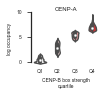

In [236]:
n,X = parse_nearest_filter('../data/human_cenpa.alphoid.sample.mono.nearest_bbox.txt',names=None)
print X.shape
bins = np.digitize(X[:,0],np.percentile(X[:,0],q=range(25,99,25)))
cscheme = ['#e41a1c','#f18c8d','#f9d1d1','#ffffff'][::-1]
# cscheme = ['#e41a1c','#f9d1d1'][::-1]


plt.figure(figsize=(1.25,1))
# plt.yscale('log')
sns.violinplot(x=bins,y=np.log(X[:,0]+1),fliersize=0,whis=1.5,width=0.7,palette=cscheme,bw=0.25,lw=1)

plt.yticks(size=5)
plt.tick_params('y',length=4)
# plt.ylim(0,200)
plt.xticks([0,1,2,3],['Q1','Q2','Q3','Q4'],size=5,y=0.05)
plt.ylabel('log occupancy',size=5)
plt.xlabel('CENP-B box strength\nquartile',size=5)
plt.title('CENP-A',size=6,y=0.9)
sns.despine(bottom=True,trim=True)
plt.tick_params('x',length=0)
# plt.savefig('../figures/cenpa_at_cenpb_quartiles_human.svg')


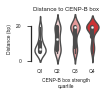

In [237]:
plt.figure(figsize=(1.25,1))
# plt.yscale('log')
sns.violinplot(x=bins,y=X[:,1],fliersize=0,whis=1.5,width=0.7,palette=cscheme,bw=0.5,lw=1)

plt.yticks(size=5)
plt.tick_params('y',length=4)
# plt.ylim(0,200)
plt.xticks([0,1,2,3],['Q1','Q2','Q3','Q4'],size=5,y=0.05)
plt.ylabel('Distance (bp)',size=5)
plt.xlabel('CENP-B box strength\nquartile',size=5)
plt.title('Distance to CENP-B box',size=6,y=0.9)
sns.despine(bottom=True,trim=True)
plt.tick_params('x',length=0)
plt.savefig('../figures/cenpb_dist_at_cenpb_quartiles_human.svg')

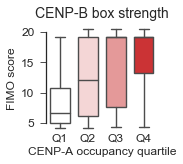

In [238]:
plt.figure(figsize=(2,2))
# plt.yscale('log')
sns.boxplot(x=bins,y=X[:,1],fliersize=0,whis=1.5,width=0.7,palette=cscheme)

plt.yticks(size=12)
# plt.ylim(0,200)
plt.xticks([0,1,2,3],['Q1','Q2','Q3','Q4'],size=12,y=0.05)
plt.ylabel('FIMO score',size=12)
plt.xlabel('CENP-A occupancy quartile',size=12)
plt.title('CENP-B box strength',size=14)
sns.despine(bottom=True,trim=True)
plt.tick_params('x',length=0)
# plt.savefig('../figures/cenpb_box_strength_human.svg')

In [90]:
spearmanr(X[:,0],X[:,1])

SpearmanrResult(correlation=0.463442941315098, pvalue=9.1616198446144267e-136)

In [115]:
n2,Y = parse_nearest_filter('../data/human_ssdna.alphoid.sample.mono.nearest_bbox.txt',names=n)

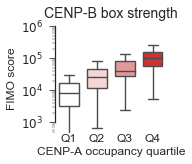

In [117]:
plt.figure(figsize=(2,2))
plt.yscale('log')
sns.boxplot(x=bins,y=1000*Y[:,0],fliersize=0,whis=1,width=0.7,palette=cscheme)
plt.yticks(size=12)
# plt.ylim(10,10000)
plt.xticks([0,1,2,3],['Q1','Q2','Q3','Q4'],size=12,y=0.05)
plt.ylabel('FIMO score',size=12)
plt.xlabel('CENP-A occupancy quartile',size=12)
plt.title('CENP-B box strength',size=14)
sns.despine(bottom=True,trim=True)
plt.tick_params('x',length=0)


In [2]:
class Interval(object):
    """Generic class for holding interval information"""
    def __init__(self,start,end,dtype=None,chrom=None,data=None,string=None,strand=None):
        self.chrom=chrom
        self.start = start
        self.end = end
        self.dtype=dtype
        self.data=data
        self.string = string
        self.strand = strand
    def __len__(self):
        return self.end-self.start
    def dist(self,I):
        x, y = sorted(((self.start,self.end), (I.start,I.end)))
            
        dist = min(y)-max(x)
        
        if dist > 0:
            return dist
        else:
            return 0
    
def bed2intervals(bedfn,col=5):
    bed = {}
    with open(bedfn,'r') as f:
        for line in f:
            line = line.rstrip().split()
            
            chrom = line[0]
            s,e = int(line[1]),int(line[2])
            score = float(line[col-1])
            strand = line[5]
            
            if chrom not in bed:
                bed[chrom] = []
            
            I = Interval(s,e,chrom=chrom,data=score,strand=strand,string='\t'.join(line))
            bed[chrom].append(I) 
    
    for chrom in bed.iterkeys():
        bed[chrom] = sorted(bed[chrom],key=lambda k:k.start)
    
    return bed

def get_closest(mono_fn,box_fn,outfn,delta=50,orientation='both'):

    def does_ovl(a1,b1,a2,b2):
        return max(a1,a2) <= min(b1,b2)
    
    def get_best(M,blist):
        if orientation != 'both':
            if orientation == 'up':
                if M.strand == '+':
                    s,e = M.start-delta,M.end
                else:
                    s,e = M.start,M.end-delta
            if orientation == 'down':
                if M.strand == "+":
                    s,e = M.start,M.end+delta
                else:
                    s,e = M.start-delta,M.end
        else:     
            s,e = M.start - delta, M.end + delta
        candidates = []
        for b in blist:
            if does_ovl(s,e,b.start,b.end):
                candidates.append(b)
        
        if len(candidates) == 0:
            return -1
        else:
            candidate = sorted(candidates,key=lambda k: (k.data,-k.start))
            return candidates[-1]
    
    
    monos = bed2intervals(mono_fn,col=9)
    boxes = bed2intervals(box_fn)
    
    out = open(outfn,'w')
    
    for chrom in monos.iterkeys():
        if chrom not in boxes:
            continue
        
        for m in monos[chrom]:
            b = get_best(m,boxes[chrom])
            
            if b == -1:
                dist = "-1"
                out.write (m.string + "\t" + str(b) +"\t"+dist+"\n")
            else:
                dist = str(m.dist(b))
                out.write(m.string+"\t"+b.string+"\t"+dist+"\n")            
            
    out.close()

In [77]:
delta = 340
bfn = '../data/human_asat.1.25kb.no_ambig.sample.1k.cenp_b.fimo.bed'
mfn = '../data/human_cenpa.alphoid.sample.mono.cvg'

get_closest(mfn,bfn,'../data/human_cenpa.alphoid.sample.mono.nearest_bbox.txt',orientation='both',delta=delta)

bfn = '../data/human_asat.1.25kb.no_ambig.sample.1k.cenp_b.fimo.bed'
mfn = '../data/human_ssdna.alphoid.sample.mono.cvg'

get_closest(mfn,bfn,'../data/human_ssdna.alphoid.sample.mono.nearest_bbox.txt',orientation='both',delta=delta)

bfn = '../data/human_asat.1.25kb.no_ambig.sample.1k.cenp_b.fimo.bed'
mfn = '../data/human_ssdna_sim.alphoid.sample.mono.cvg'

# get_closest(mfn,bfn,'../data/human_ssdna_sim.alphoid.sample.mono.nearest_bbox.txt',orientation='both',delta=delta)

# bfn = '../data/human_asat.1.25kb.no_ambig.sample.1k.cenp_b.fimo.bed'
# mfn = '../data/human_wgs.alphoid.sample.mono.cvg'

# get_closest(mfn,bfn,'../data/human_wgs.alphoid.sample.mono.nearest_bbox.txt',orientation='both',delta=delta)

bfn = '../data/human_asat.1.25kb.no_ambig.sample.1k.cenp_b.fimo.bed'
mfn = '../data/human_input.alphoid.sample.mono.cvg'

get_closest(mfn,bfn,'../data/human_input.alphoid.sample.mono.nearest_bbox.txt',orientation='both',delta=delta)

#### Mouse

In [337]:
bfn = '../data/misat_118-122.1kb.cenp_b.fimo.bed'
mfn = '../data/mouse_cenpa.misat.mono.cvg'

get_closest(mfn,bfn,'../data/mouse_cenpa.misat.mono.nearest_bbox.txt',orientation='both',delta=20)

bfn = '../data/misat_118-122.1kb.cenp_b.fimo.bed'
mfn = '../data/mouse_input.misat.mono.cvg'

get_closest(mfn,bfn,'../data/mouse_input.misat.mono.nearest_bbox.txt',orientation='both',delta=20)

bfn = '../data/misat_118-122.1kb.cenp_b.fimo.bed'
mfn = '../data/mouse_ssdna_activ.misat.mono.cvg'

get_closest(mfn,bfn,'../data/mouse_ssdna_activ.misat.mono.nearest_bbox.txt',orientation='both',delta=20)

bfn = '../data/misat_118-122.1kb.cenp_b.fimo.bed'
mfn = '../data/mouse_ssdna_rest.misat.mono.cvg'

get_closest(mfn,bfn,'../data/mouse_ssdna_rest.misat.mono.nearest_bbox.txt',orientation='both',delta=20)


bfn = '../data/misat_118-122.1kb.cenp_b.fimo.bed'
mfn = '../data/mouse_wgs.misat.mono.cvg'

get_closest(mfn,bfn,'../data/mouse_.mono.nearest_bbox.txt',orientation='both',delta=20)

bfn = '../data/misat_118-122.1kb.cenp_b.fimo.bed'
mfn = '../data/mouse_ssdna_control.misat.mono.cvg'

get_closest(mfn,bfn,'../data/mouse_ssdna_control.misat.mono.nearest_bbox.txt',orientation='both',delta=20)

In [ ]:
n,X = parse_nearest_filter('../data/mouse_cenpa.misat.mono.nearest_bbox.txt',names=None,
                          normbed='../data/mouse_ssdna_control.misat.mono.nearest_bbox.txt')
print X.shape
bins = np.digitize(X[:,0],np.percentile(X[:,0],q=range(50,100,50)))
cscheme = ['#e41a1c','#ffffff'][::-1]
# cscheme = ['#e41a1c','#f9d1d1'][::-1]


plt.figure(figsize=(1.25,1))
# plt.yscale('log')
sns.boxplot(x=bins,y=X[:,0],fliersize=0,whis=1.5,width=0.7,palette=cscheme)




plt.yticks(size=5)
plt.tick_params('y',length=4)
# plt.ylim(0,1000)
plt.xticks([0,1,2,3],['Q1','Q2','Q3','Q4'],size=5,y=0.05)
plt.ylabel('log occupancy',size=5)
plt.xlabel('CENP-B box strength\nquartile',size=5)
plt.title('CENP-A',size=6,y=0.9)
sns.despine(bottom=True,trim=True)
plt.tick_params('x',length=0)
# plt.savefig('../figures/cenpa_at_cenpb_quartiles_human.svg')



In [5]:
def per_read_summation(cvgfn,log=False,scale=1):
    reads = {}
    with open(cvgfn,'r') as f:
        for line in f:
            line = line.strip().split()
            val = float(line[8])
            if val == 0:
                continue
            if line[0] not in reads:
                reads[line[0]] = val
            else:
                reads[line[0]] += val
    
    for rname in reads.keys():
        reads[rname] *= scale
        if log:
            reads[rname] = np.log(reads[rname])
    
    return reads


def per_read_boxes(bedfn,thresh=1e-3,score=False):
    reads = {}
    with open(bedfn,'r') as f:
        for line in f:
            line = line.strip().split()
            pv = float(line[4])
            if pv <= thresh:
                
                if score:
                    val = float(line[-2])
                else:
                    val = 1
                
                if line[0] not in reads:
                    reads[line[0]] = val
                else:
                    reads[line[0]] += val
    return reads

def get_lens(lenfn):
    lens = {}
    with open(lenfn,'r') as f:
        for line in f:
            line = line.rstrip().split()
            lens[line[0]] = int(line[1])
    return lens

def corr_dicts(r1,r2):
    data = []
    
    name_order = []
    for rname in set(r1.keys()).intersection(set(r2.keys())):
        data.append([r1[rname],r2[rname]])
        name_order.append(rname)
    return name_order,np.array(data)

def corr_files(cvgfn1,cvgfn2,scale1=1,scale2=1):
    r1 = per_read_summation(cvgfn1,scale=scale1)
    r2 = per_read_summation(cvgfn2,scale=scale2)
    
    return corr_dicts(r1,r2)
    
def norm_file(cvgfn1,cvgfn2,scale1=1,scale2=1,log=True):
    r1 = per_read_summation(cvgfn1,scale=scale1)
    r2 = per_read_summation(cvgfn2,scale=scale2)
    
    normed = {}
    
    for rname in set(r1.keys()).intersection(set(r2.keys())):
        if r2[rname] == 0:
            continue
        if log:
            normed[rname] = np.log2(r1[rname]+1)-np.log2(r2[rname]+1)
        else:
            normed[rname] = (r1[rname]+1)/(r2[rname]+1)
    return normed

In [6]:
# boxes = per_read_boxes('../data/misat_118-122.1kb.cenp_b.fimo.bed',score=False,thresh=1e-7)
boxes = per_read_boxes('../data/human_asat.1.25kb.cenp_b.fimo.bed',score=True,thresh=0.95e-7)
asats = per_read_boxes('../data/human_asat.1.25kb.no_ambig.sample.alphoid.bed',score=False,thresh=np.inf)

lens = get_lens('../data/human_asat.1.25kb.no_ambig.sizes')

In [7]:
f1 = '../data/human_cenpa.alphoid.sample.mono.nearest_bbox.txt'
n1 = '../data/human_input.alphoid.sample.mono.cvg'

f2 = '../data/human_ssdna.alphoid.sample.mono.nearest_bbox.txt'
n2 = '../data/human_wgs.alphoid.sample.mono.cvg'

# f1_s = 3e8*(18557894+127084)/32167098
f1_s = 3e9/(18557894+127084)
n1_s = (63428+12140)/17828342
# n1_s = 3e9/(63428+12140)

f2_s = (5748089+4523061)/116355230
# f2_s = 3e9/(5748089+4523061)

# SIM
# n2_s = 3e8*(42103008+2075713)/54820904
# n2_s = 3e9/(42103008+2075713)

# WGS
n2_s = (8341837+1108237)/307767790
# n2_s = 3e9/(8341837+1108237)
# n1_s = n2_s


# d1 = norm_file(f1,n1,f1_s,n1_s,log=False)
d1 = per_read_summation(f1,log=False,scale=f1_s)
d1n = per_read_summation(n1,log=False,scale=n1_s)
# d2 = norm_file(f2,n2,f2_s,n2_s,log=False)
d2 = per_read_summation(f2,log=False,scale=f2_s)
d2n = per_read_summation(n2,log=False,scale=n2_s)



for rname in d1.keys():
#     if rname in asats and rname in lens:
#         d1[rname] *= (asats[rname]/lens[rname])
    if rname in d1n and rname in asats:
        d1[rname] /= (d1n[rname])#*(lens[rname]/asats[rname])
    else:
        del d1[rname]

for rname in d2.keys():
#     if rname in asats and rname in lens:
#         d2[rname] *= (asats[rname]/lens[rname])      
    if rname in d2n and rname in asats:
#         d2[rname] /= (d2n[rname])#*(lens[rname]/asats[rname])
        continue
    else:
        del d2[rname]

order,X = corr_dicts(d1,d2)

print X.shape

(843, 2)


In [8]:
c = []
for rname in order:
    if rname in boxes:
        c.append(boxes[rname])
    else:
        c.append(-1)
c = np.array(c)

bins = np.percentile(c,q=np.arange(25,76,25))
binned = np.digitize(c,bins)
# cdict = {1:cm.Paired(0),2:cm.Paired(1),3:cm.Paired(4),4:cm.Paired(5)}
# cdict = {4:'#e41a1c',3:'#f18c8d',2:'#f9d1d1',1:'lightgrey'}
cdict = {3:'#e41a1c',2:'#f18c8d',1:'grey'}


colors = [cdict[cc] for cc in binned]


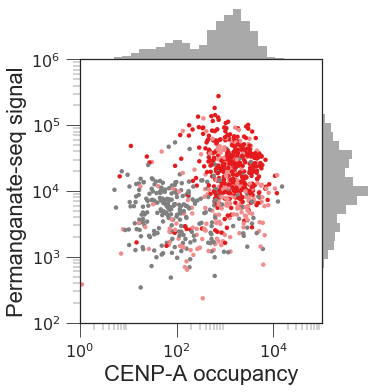

In [37]:
xmin = np.floor(np.log(np.min(X[:,0]/10000)))
xmax = np.ceil(np.log(np.max(X[:,0]/10000)))
ymin = np.floor(np.log(np.min(X[:,1])))
ymax = np.ceil(np.log(np.max(X[:,1])))

xbins=np.logspace(xmin,xmax,75)
ybins=np.logspace(2,6,30)

g = sns.JointGrid(X[:,0]/10000,X[:,1],xlim=[10**0,10**5],ylim=[10**2,10**6],space=0,size=5)
# g = sns.JointGrid(X[:,0],X[:,1],space=0,size=2.5)


g.ax_marg_x.hist(X[:,0]/10000, color='darkgrey', alpha=1,bins=xbins)
g.ax_marg_y.hist(X[:,1], color='darkgrey', alpha=1,bins=ybins,orientation='horizontal')
g.plot_joint(plt.scatter, color=colors ,s=20,lw=0,zorder=1,rasterized=True)

ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')
g.ax_marg_y.tick_params(which='both',length=0)
g.ax_marg_x.tick_params(which='both',length=0)

ax.tick_params(labelsize=16,length=14)
ax.tick_params(length=7, which='minor')
ax.set_xlabel('CENP-A occupancy',size=22)
ax.set_ylabel('Permanganate-seq signal',size=22)

plt.savefig('../figures/human_corr_cenp_b_boxes.svg',dpi=300)

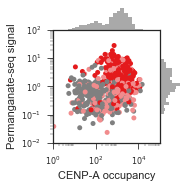

In [48]:
xmin = np.floor(np.log(np.min(X[:,0]/10000)))
xmax = np.ceil(np.log(np.max(X[:,0]/10000)))
ymin = np.floor(np.log(np.min(X[:,1]/10000)))
ymax = np.ceil(np.log(np.max(X[:,1]/10000)))

xbins=np.logspace(xmin,xmax,75)
ybins=np.logspace(ymin,ymax,75)

g = sns.JointGrid(X[:,0]/10000,X[:,1]/10000,space=0,size=2.5,
                 xlim=[10**0,10**5],ylim=[1e-2,10**2])

g.ax_marg_x.hist(X[:,0]/10000, color='darkgrey', alpha=1,bins=xbins)
g.ax_marg_y.hist(X[:,1]/10000, color='darkgrey', alpha=1,bins=ybins,orientation='horizontal')
# g.ax_joint.axvspan(np.exp(xmin),np.exp(-1.25),np.exp(ymin),np.exp(ymax),color='grey',zorder=0,alpha=0.1)
# g.ax_joint.axhspan(np.exp(ymin),np.exp(-1.2),np.exp(xmin),np.exp(xmax),color='grey',zorder=0,alpha=0.1)
# g.ax_joint.axvspan(np.exp(-1.25),np.exp(xmax),np.exp(-0.76),np.exp(ymax),color='red',zorder=0,alpha=0.1)
g.plot_joint(plt.scatter, color=colors,s=25,lw=0,zorder=1,rasterized=True)

ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')
g.ax_marg_y.tick_params(which='both',length=0)
g.ax_marg_x.tick_params(which='both',length=0)

ax.tick_params(labelsize=8)
ax.set_xlabel('CENP-A occupancy',size=11)
ax.set_ylabel('Permanganate-seq signal',size=11)

plt.savefig('../figures/human_corr_cenp_b_boxes.svg',dpi=300)

In [58]:
# boxes = per_read_boxes('../data/misat_118-122.1kb.cenp_b.fimo.bed',score=False,thresh=1e-7)
boxes = per_read_boxes('../data/misat_118-122.1kb.cenp_b.fimo.bed',score=True,thresh=0.95e-7)
asats = per_read_boxes('../data/misat.118-122.1kb.misat.blast.bed',score=False,thresh=np.inf)

c = []
for rname in order:
    if rname in boxes:
        c.append(boxes[rname])
    else:
        c.append(-1)
c = np.array(c)

bins = np.percentile(c,q=np.arange(33,67,33))
binned = np.digitize(c,bins)
# cdict = {1:cm.Paired(0),2:cm.Paired(1),3:cm.Paired(4),4:cm.Paired(5)}
# cdict = {3:'#e41a1c',2:'#f18c8d',1:'#f9d1d1',0:'lightgrey'}
cdict = {2:'#e41a1c',1:'#f18c8d',0:'grey'}

colors = [cdict[cc] for cc in binned]


In [57]:
f1 = '../data/mouse_cenpa.misat.mono.cvg'
n1 = '../data/mouse_input.misat.mono.cvg'

f2 = '../data/mouse_ssdna_activ.misat.mono.cvg'
n2 = '../data/mouse_ssdna_control.misat.mono.cvg'


d1 = norm_file(f1,n1,1,1,log=False)
# d1 = per_read_summation(f1,log=False,scale=1)
# d1n = per_read_summation(n1,log=False,scale=1)
d2 = norm_file(f2,n2,1,1,log=False)
# d2 = per_read_summation(f2,log=False,scale=1)
# d2n = per_read_summation(n2,log=False,scale=1)

# for rname in d1.keys():
#     if rname in d1n:
#         d1[rname] /= d1n[rname]
#     else:
#         del d1[rname]

# for rname in d2.keys():
#     if rname in d2n:
#         d2[rname] /= d2n[rname]
#     else:
#         del d2[rname]

order,X = corr_dicts(d1,d2)

print X.shape

(203, 2)


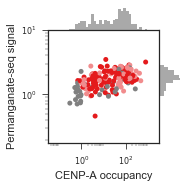

In [59]:
xmin = np.floor(np.log(np.min(X[:,0])))
xmax = np.ceil(np.log(np.max(X[:,0])))
ymin = np.floor(np.log(np.min(X[:,1])))
ymax = np.ceil(np.log(np.max(X[:,1])))

xbins=np.logspace(xmin,xmax,75)
ybins=np.logspace(ymin,ymax,75)

g = sns.JointGrid(X[:,0],X[:,1],xlim=[10**-1.5,10**3.5],ylim=[10**-0.75,10**1],space=0,size=2.5)

g.ax_marg_x.hist(X[:,0], color='darkgrey', alpha=1,bins=xbins)
g.ax_marg_y.hist(X[:,1], color='darkgrey', alpha=1,bins=ybins,orientation='horizontal')
# g.ax_joint.axvspan(np.exp(xmin),np.exp(-1.25),np.exp(ymin),np.exp(ymax),color='grey',zorder=0,alpha=0.1)
# g.ax_joint.axhspan(np.exp(ymin),np.exp(-1.2),np.exp(xmin),np.exp(xmax),color='grey',zorder=0,alpha=0.1)
# g.ax_joint.axvspan(np.exp(-1.25),np.exp(xmax),np.exp(-0.76),np.exp(ymax),color='red',zorder=0,alpha=0.1)
g.plot_joint(plt.scatter, color=colors,s=25,lw=0,zorder=1,rasterized=True)

ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')
g.ax_marg_y.tick_params(which='both',length=0)
g.ax_marg_x.tick_params(which='both',length=0)

ax.tick_params(labelsize=8)
ax.set_xlabel('CENP-A occupancy',size=11)
ax.set_ylabel('Permanganate-seq signal',size=11)

plt.savefig('../figures/mouse_corr_cenp_b_boxes.svg',dpi=300)